In [1]:
# import libraries
import torch
import numpy as np
from dataloader import get_dataloader_vae
from dataloader import get_dataloader_OOD
from utils import extract_feature_maps
from models import get_trained_model
#from energy import ELOOD
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class for energy-like ood detection
class ELOOD:
    def __init__(self, model, T=10000):
        self.model = model.to(device)
        self.T = T
    
    # get energy function values
    # input size = [batch, n]
    # output size = [batch]
    def energy_vals(self, feats):

        # Perform element-wise division by T
        feats = np.divide(feats, self.T)      

        # Get the exponential of all values in the tensor
        feats = np.exp(feats)
        
        # Compute row-wise sum
        total = np.zeros(feats.shape[0])
        for i in range(feats.shape[0]):
            total[i] = np.sum(feats[i]) 

        # get log values
        total = np.log(total)

        # Perform element-wise multiplication by -T
        total = np.multiply(total, -self.T)

        return total


    # helper function to get free energy term [second term in energy function]
    def get_free_energy(self, feats):
        # Perform element-wise division by T
        feats = np.divide(feats, self.T) 

        # Perform element-wise multiplication by -1
        feats = np.multiply(feats, -1)

        # Compute row-wise sum
        total = np.zeros(feats.shape[0])
        for i in range(feats.shape[0]):
            total[i] = np.sum(feats[i]) 

        # get log values
        total = np.log(total)

        return total
        
    # get ood scores 
    def get_scores(self, loader):
        ood_scores = []
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            
            # get feature maps
            feats = extract_feature_maps(self.model, images)

            # get latent space representation
            _, _, _, z = self.model(images)

            # append z to feats
            feats.append(z.detach().cpu().data.numpy())

            # get energy function scores
            feats = [self.energy_vals(elem) for elem in feats]

            feats = np.array(feats)
            feats = feats.T

            # find score for z
            z_energy = self.energy_vals(z.detach().cpu().data.numpy())

            # get scores
            scores = np.divide(z_energy, self.T) + self.get_free_energy(feats)

            # add scores to list
            ood_scores.extend(scores)

        return ood_scores

In [3]:
model = get_trained_model('CIFAR10')
# get dataloaders
train_dl, test_dl = get_dataloader_vae('CIFAR10')
svhn_dl = get_dataloader_OOD('SVHN')
det = ELOOD(model)

Files already downloaded and verified
Using downloaded and verified file: data\test_32x32.mat


In [4]:
print("for c10")
c10 = det.get_scores(train_dl)
print("for svhn")
sv = det.get_scores(svhn_dl)

for c10
for svhn


In [5]:
len(c10), len(sv)

(50000, 26032)

In [6]:
def statdesc(data):
    ## Statistical Descriptors

    # Mean
    mean = np.mean(data)
    print(f"Mean: {mean}")

    # Median
    median = np.median(data)
    print(f"Median: {median}")

    # Standard Deviation
    std_dev = np.std(data)
    print(f"Standard Deviation: {std_dev}")

    # Quartiles
    quartiles = np.quantile(data, [0.25, 0.5, 0.75])
    print(f"Quartiles: {quartiles}")

    # Interquartile Range (IQR)
    iqr = quartiles[2] - quartiles[0]
    print(f"Interquartile Range (IQR): {iqr}")

    # Minimum and Maximum
    data_min = np.min(data)
    data_max = np.max(data)
    print(f"Minimum: {data_min}")
    print(f"Maximum: {data_max}")

In [7]:
statdesc(c10)
print()
statdesc(sv)

Mean: -0.38807291778656217
Median: -0.3880655569528515
Standard Deviation: 4.203369831825865e-05
Quartiles: [-0.38809339 -0.38806556 -0.38804424]
Interquartile Range (IQR): 4.9150015360988064e-05
Minimum: -0.38827690075566323
Maximum: -0.38796923184740173

Mean: -0.38809572420486194
Median: -0.38806842835162136
Standard Deviation: 7.489117398793272e-05
Quartiles: [-0.38816751 -0.38806843 -0.38803495]
Interquartile Range (IQR): 0.00013256188831212157
Minimum: -0.3882970690764589
Maximum: -0.3879497528466871


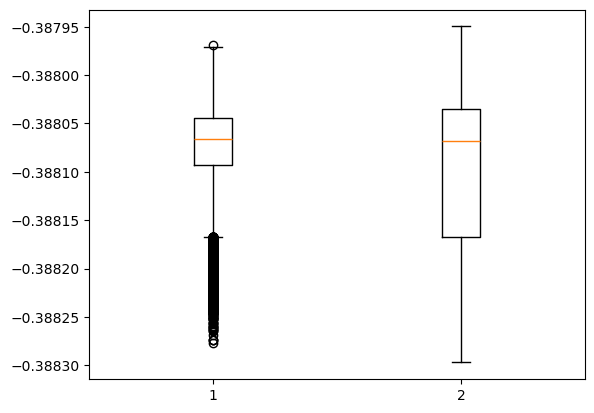

In [8]:
# Plot
plt.boxplot([c10, sv])

# Display the plot
plt.show()